In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import

from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression,  RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import NearMiss
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix,classification_report, precision_recall_curve

sys.path.append("..")

from models.ClassificationMetrics import myBinaryConfusionMatrix, myClassificationReport
from models.kneighbors import kNN

NameError: name 'sys' is not defined

# Загрузка датасета

Инициализируем датасет 

In [ ]:
data = pd.read_csv('../data/weatherAUS.csv')
pd.set_option('display.max_columns', 30)
data

Заметим, что в датасете есть пропуски. Рассмотрим процент пропусков в каждом из столбцов:

In [ ]:
data.info()

In [ ]:
(data.isna().sum()/data.shape[0]*100).sort_values(ascending=False)

# Подготовка данных

## Обработка пропущенных значений

Проверим число явных дубликатов:

In [ ]:
data.duplicated().sum()

Поскольку процент пропусков в Sunshine, Evaporation, Cloud3pm, Cloud9am несоразмерно велик по сравнению с любым другим столбцом, рассмотрим их отдельно. Поэтому для начала заполним модой данные в остальных столбцах, кроме RainTomorrow. Все пропуски в нем удалим для достоверности целевого признака.

In [ ]:
data.dropna(inplace = True, subset=['RainTomorrow'])

In [ ]:
columns = ['Pressure9am', 'Pressure3pm', 'WindDir9am', 'WindGustDir',      
            'WindGustSpeed', 'Humidity3pm', 'WindDir3pm', 'Temp3pm',   
            'Rainfall', 'RainToday', 'WindSpeed3pm', 'Humidity9am', 
            'Temp9am', 'WindSpeed9am', 'MinTemp',  'MaxTemp']  

for column in columns:
    mode = data[column].mode().iat[0]
    data[column].fillna(mode, inplace = True)

In [ ]:
(data.isna().sum()/data.shape[0]*100).sort_values(ascending=False)

Рассмотрим гистограммы, чтобы оценить результат действий:

In [ ]:
data.info()

In [ ]:
columns.remove('WindGustDir')
columns.remove('WindDir9am')
columns.remove('WindDir3pm')
columns.remove('RainToday')

for column in columns:
    data.hist(column, bins = 50)

Аномалии возникли в Pressure9am, Pressure3pm, Humindity3pm, Rainfall, Humindity9am. Можно заметить, что без них распределение близко к нормальному. В то же время удаление проблемных данных приведет к значительному уменьшению размера выборки. Поэтому принято решение оставить датасет в текущем виде.

Рассмотрим  Sunshine, Evaporation, Cloud3pm, Cloud9am:

In [ ]:
columns = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']
for column in columns:
    data.hist(column, bins = 50)

In [ ]:
for column in columns:
    mode = data[column].mode().iat[0]
    data[column].fillna(mode, inplace = True)

for column in columns:
    data.hist(column, bins = 50)

Поскольку заполнение пропусков в столбце Sunshine сильно искажает исходный вид данных, собирая результаты большинства наблюдений в окрестности нуля (т.е. делая почти все дни в Австралии пасмурными), это сделает признак малоинформативным. В то же время общее распределение данных в Evaporation сильно не меняется, а Cloud3pm и Cloud9am это происходит в целом умеренно (другие данные хорошо различимы на фоне моды). Поэтому от столбца Sunshine проще всего избавиться.

In [ ]:
data.drop(['Sunshine'], axis=1, inplace = True)

In [ ]:
(data.isna().sum()/data.shape[0]*100).sort_values(ascending=False)

## Кодирование категориальных признаков

In [ ]:
cat_columns = ['Location', 'RainToday', 'WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainTomorrow']

In [ ]:
for column in cat_columns:
    print(data[column].unique())

Применим к Location и всем Wind... порядковое кодирование

In [ ]:
ordinal_features = ['Location', 'WindDir9am', 'WindGustDir', 'WindDir3pm', 'RainToday']
ordinal_encoder = OrdinalEncoder()

ct = ColumnTransformer(transformers=[
     ('ord', ordinal_encoder, ordinal_features)
])

ct.set_output(transform='pandas')
encoded_features = ct.fit_transform(data)
encoded_features.head(20)

In [ ]:
encoded_features.info()

Закодируем целевой признак и добавим в фрейм к уже обработанным значениям

In [ ]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(data['RainTomorrow'])
encoded_data = encoded_features.assign(RainTomorrow=encoded_label)
encoded_data.head()

In [ ]:
encoded_data.info()

Удалим обработанные ранее столбцы из исходного фрейма

In [ ]:
data.drop(cat_columns, axis = 1, inplace = True)
data.head()

In [ ]:
data.info()

Произведем конкатенацию столбцов исходного фрейма и фрейма с обработанными данными

In [ ]:
data = pd.concat([data.reset_index(drop = True), encoded_data.reset_index(drop = True)], axis = 1)
data.head()

Поскольку столбец с датой неинформативен в своем исходном виде, преобразуем значения в соответствующие месяца

In [ ]:
data['Date'] = pd.Series(pd.to_datetime(data['Date'].values).month)

In [ ]:
data['Date'].unique()

In [ ]:
data.head(30)

In [ ]:
data.to_csv ('../data/rainAUS_prepared', index= False)

# Разделение выборки

Выделим столбец с целевым признаком, 

In [27]:
y = data['RainTomorrow']
X = data.drop(['RainTomorrow'], axis=1)

In [28]:
y

0         0
1         0
2         0
3         0
4         0
         ..
142188    0
142189    0
142190    0
142191    0
142192    0
Name: RainTomorrow, Length: 142193, dtype: int32

Проверим уровень дизбаланса между классами 

In [29]:
yes = data[data['RainTomorrow'] == 1]['RainTomorrow'].count()


In [30]:
no = data['RainTomorrow'].count() - yes

In [31]:
print(f'{round((yes/no)*100)}%')

29%


Разделим датасеты на тренировочные и тестовые выборки, используя ресемплирование для train

In [32]:
nm = NearMiss()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((113754, 21), (113754,), (28439, 21), (28439,))

In [35]:
X_train, y_train = nm.fit_resample(X_train, y_train.ravel())

In [36]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50972, 21), (50972,), (28439, 21), (28439,))

# Масштабирование

In [37]:
scaler = StandardScaler()

In [38]:
scaler.fit(X_train)

StandardScaler()

In [39]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
X_train

array([[-0.74564984, -0.51842934, -0.24971773, ...,  1.05326675,
         0.30989826, -0.68750886],
       [-1.05267752, -0.51842934, -0.24971773, ...,  1.05326675,
         0.30989826, -0.68750886],
       [-1.05267752, -0.51842934, -0.24971773, ...,  1.05326675,
         0.30989826, -0.68750886],
       ...,
       [ 0.78948856, -1.16110537,  0.25753792, ..., -0.92330169,
        -0.60665652, -0.68750886],
       [ 1.7105716 ,  1.56634899,  1.13370677, ..., -0.48406426,
        -1.0649339 , -0.68750886],
       [-0.74564984, -0.04817859, -0.61863093, ...,  1.05326675,
         1.22645304,  1.4545267 ]])

# Создание и обучение моделей классификации

Функции для вывода метрик

In [41]:
def show_metrics(y_test, predict):
    print(classification_report(y_test, predict))    

def show_roc(X_test, y_test, model):
    %matplotlib inline
    
    y_scores = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    
    fig = plt.figure(figsize=(6, 6))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print(f'AUC: {roc_auc_score(y_test, y_scores[:,1])}')

def show_con_mat(y_test, predict):
    print(confusion_matrix(y_test, predict))

## Логистическая регрессия

In [42]:
params = {'C': np.arange(0.01, 1, 0.1)}

In [43]:
lr_optimal = GridSearchCV(LogisticRegression(), params).fit(X_train, y_train)
lr_optimal.best_params_

{'C': 0.11}

In [44]:
lr = LogisticRegression(C = lr_optimal.best_params_['C'])
lr.fit(X_train, y_train)
predict = lr.predict(X_test)

In [45]:
show_con_mat(y_test, predict)

[[17351  4697]
 [ 1907  4484]]


In [46]:
show_metrics(y_test, predict)

              precision    recall  f1-score   support

           0       0.90      0.79      0.84     22048
           1       0.49      0.70      0.58      6391

    accuracy                           0.77     28439
   macro avg       0.69      0.74      0.71     28439
weighted avg       0.81      0.77      0.78     28439

f1_score: 0.5759054713588492


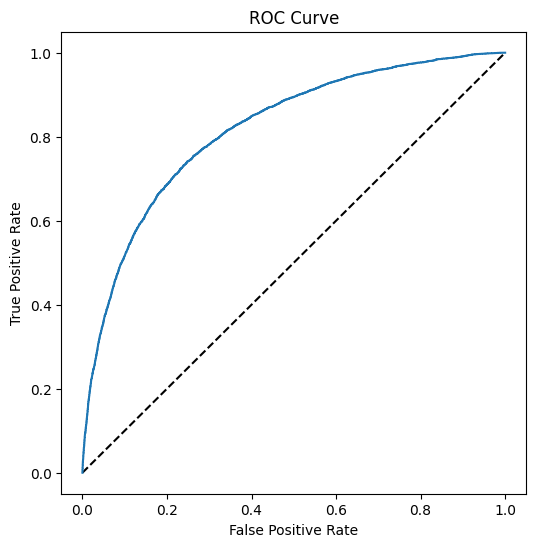

AUC: 0.8185306254327622


In [47]:
show_roc(X_test, y_test, lr)

Видим, что модель предсказывает реальные значения хорошо: ROC кривая по форме близка к идеальному варианту, метрики для первого класса достаточно высоки, а для второго в пределах адекватных.

## Метод k ближайших соседей

In [48]:
params = {'n_neighbors': np.arange(1, 15, 2)}
knn_optimal = GridSearchCV(KNeighborsClassifier(), params).fit(X_train, y_train)
knn_optimal.best_params_

{'n_neighbors': 13}

In [49]:
knn = KNeighborsClassifier(n_neighbors = knn_optimal.best_params_['n_neighbors'], weights = 'distance')

In [50]:
knn.fit(X_train, y_train)
predict = knn.predict(X_test)

In [51]:
show_con_mat(y_test, predict)

[[17167  4881]
 [ 2317  4074]]


In [52]:
show_metrics(y_test, predict)

              precision    recall  f1-score   support

           0       0.88      0.78      0.83     22048
           1       0.45      0.64      0.53      6391

    accuracy                           0.75     28439
   macro avg       0.67      0.71      0.68     28439
weighted avg       0.79      0.75      0.76     28439

f1_score: 0.5309526912550502


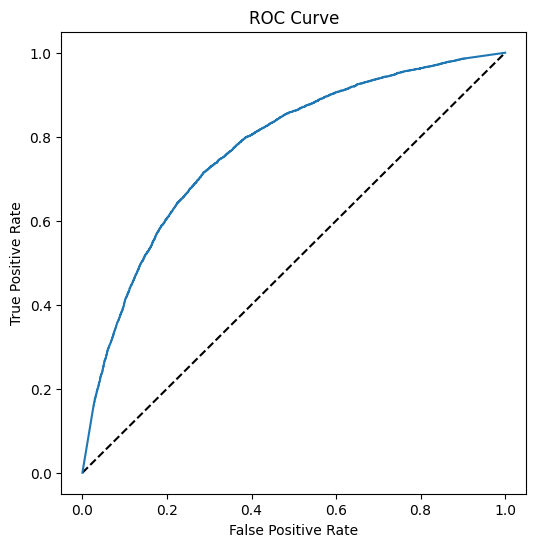

AUC: 0.7747313957070436


In [53]:
show_roc(X_test, y_test, knn)

Из значений метрик видно, что kNN, использующий евклидову метрику (с поиском k по сетке) справляется с задачей классификации немного хуже, чем логистическая регрессия.

## Наивный байесовский классификатор

### Gaussian

In [54]:
params = {'var_smoothing': np.arange(0, 0.01, 1)}
gs_nb_optimal = GridSearchCV(GaussianNB(), params).fit(X_train, y_train)
gs_nb_optimal.best_params_

{'var_smoothing': 0.0}

In [55]:
gs_nb = GaussianNB()
gs_nb.fit(X_train, y_train)

GaussianNB()

In [56]:
predict = gs_nb.predict(X_test)

In [57]:
show_con_mat(y_test, predict)

[[17128  4920]
 [ 2573  3818]]


In [58]:
show_metrics(y_test, predict)

              precision    recall  f1-score   support

           0       0.87      0.78      0.82     22048
           1       0.44      0.60      0.50      6391

    accuracy                           0.74     28439
   macro avg       0.65      0.69      0.66     28439
weighted avg       0.77      0.74      0.75     28439

f1_score: 0.5047260228699848


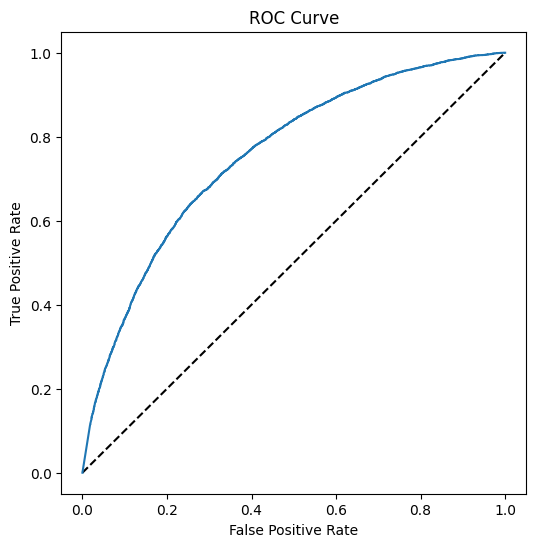

AUC: 0.7561118836834908


In [59]:
show_roc(X_test, y_test, gs_nb)

Из метрик видно, что гауссовский наивный байес справился с задачей хуже всех остальных рассмотренных классификаторов.

## SVM

In [63]:
params = {'C': np.arange(0.01, 0.1, 1), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2,3], 'gamma': ['scale', 'auto']}
svc_optimal = GridSearchCV(SVC(), params).fit(X_train, y_train)
svc_optimal.best_params_

{'C': 0.01, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
#{'C': 0.01, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

In [64]:
c = svc_optimal.best_params_['C']
gamma = svc_optimal.best_params_['gamma']
kernel = svc_optimal.best_params_['kernel']

In [70]:
svc = SVC(C = c, gamma = gamma, kernel = kernel, probability=True)
svc.fit(X_train, y_train)

SVC(C=0.01, probability=True)

In [72]:
predict = svc.predict(X_test)

In [73]:
show_con_mat(y_test, predict)

[[15169  6879]
 [ 1850  4541]]


In [74]:
show_metrics(y_test, predict)

              precision    recall  f1-score   support

           0       0.89      0.69      0.78     22048
           1       0.40      0.71      0.51      6391

    accuracy                           0.69     28439
   macro avg       0.64      0.70      0.64     28439
weighted avg       0.78      0.69      0.72     28439

f1_score: 0.509909606422997


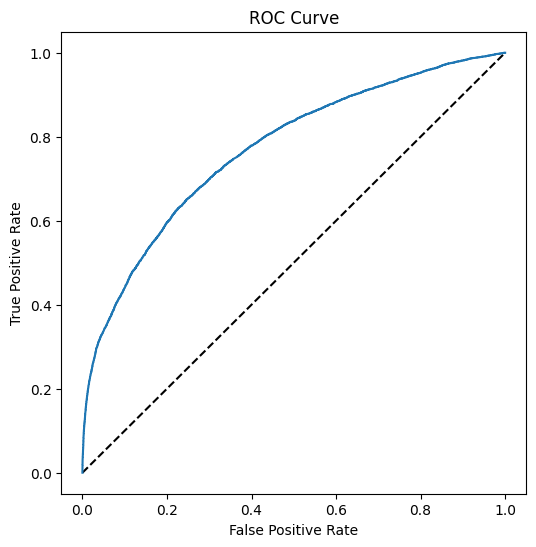

AUC: 0.7698880278337257


In [75]:
show_roc(X_test, y_test, svc)

Исходя из метрик, модель RBF заметно не улучшила результаты классификации.

# Построение итоговой модели классификаторов

In [79]:
classifiers = {
    'Logistic Regression': LogisticRegression(C = 0.11),
    'Naive Bayes' : GaussianNB(),
    'SVC': SVC(kernel='rbf', C= 0.01, gamma = 'scale', probability=True),
    'KNN classifier': KNeighborsClassifier(n_neighbors=13, metric='minkowski', weights='distance')
}

In [80]:
n_classifiers = len(classifiers)

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train, np.ravel(y_train))

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))
    print(classification_report(y_test,y_pred))

Accuracy (train) for Logistic Regression: 76.8% 
              precision    recall  f1-score   support

           0       0.90      0.79      0.84     22048
           1       0.49      0.70      0.58      6391

    accuracy                           0.77     28439
   macro avg       0.69      0.74      0.71     28439
weighted avg       0.81      0.77      0.78     28439

Accuracy (train) for Naive Bayes: 73.7% 
              precision    recall  f1-score   support

           0       0.87      0.78      0.82     22048
           1       0.44      0.60      0.50      6391

    accuracy                           0.74     28439
   macro avg       0.65      0.69      0.66     28439
weighted avg       0.77      0.74      0.75     28439

Accuracy (train) for SVC: 69.3% 
              precision    recall  f1-score   support

           0       0.89      0.69      0.78     22048
           1       0.40      0.71      0.51      6391

    accuracy                           0.69     28439
   ma

В результате, наилучшие метрики имеет модель логистической регрессии.

## Собственные метрики

In [ ]:
n_classifiers = len(classifiers)
con_mtx = myBinaryConfusionMatrix(y_test.values, y_pred)
print(con_mtx)
print()

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train, np.ravel(y_train))

    y_pred = classifier.predict(X_test)
    myClassificationReport(y_test.values, y_pred)
    print()

# Реализация kNN

In [225]:
my_X_train = X_train[5000:50000:100]
my_y_train = y_train[5000:50000:100]
my_X_test = X_test[20000:30000:50]
my_y_test = y_test[20000:30000:50]

In [226]:
my_knn = kNN(3)

In [227]:
my_knn.fit(my_X_train, my_y_train)
predict = my_knn.predict(my_X_test)

In [229]:
show_con_mat(my_y_test, predict)

[[83 45]
 [13 28]]


In [228]:
print(predict)

[0 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 1
 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0
 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0
 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1]


In [231]:
show_metrics(my_y_test, predict)

              precision    recall  f1-score   support

           0       0.86      0.65      0.74       128
           1       0.38      0.68      0.49        41

    accuracy                           0.66       169
   macro avg       0.62      0.67      0.62       169
weighted avg       0.75      0.66      0.68       169

f1_score: 0.4912280701754387


# Задание

Какова вероятность отправиться на прогулку если идёт дождь, при наличии следующих наблюдений?

In [233]:
data = [
        ('солнечно', True),
        ('снег', False),
        ('облачно', False),
        ('дождь', False),
        ('солнечно', True),
        ('снег', False),
        ('облачно', True),
        ('снег', False),
        ('солнечно', False),
        ('облачно', True),
        ('снег', True),
        ('солнечно', True),
        ('дождь', False),
        ('дождь', True),
        ('облачно', True),
]

In [234]:
data = pd.DataFrame(data, columns=['weather', 'iswalking'])
data

,weather,iswalking
0,солнечно,True
1,снег,False
2,облачно,False
3,дождь,False
4,солнечно,True
5,снег,False
6,облачно,True
7,снег,False
8,солнечно,False
9,облачно,True


In [235]:
rain_data = data[data['weather'] == 'дождь']

In [239]:
prob = len(rain_data[rain_data['iswalking'] == True])/len(rain_data)

In [240]:
print(prob)

0.3333333333333333
